In [30]:
import pandas as pd

# Load the dataset
try:
    df = pd.read_csv("CICIDS2017_FINAL.csv", nrows=50000)
except FileNotFoundError:
    print("Error: 'combine.csv' file not found.")
    exit()

# Remove any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check if required columns exist
required_columns = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s', 'FIN Flag Count'
]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"Error: Missing columns in dataset: {missing_columns}")
    exit()

# Define the classification rules for DDoS detection
def detect_ddos(row):
    try:
        if ((row['Flow Duration'] > 5000000) or (row['Flow Duration'] >= 1000000)) or \
           ((row['Flow Bytes/s'] > 1e7) and (row['Fwd Packets/s'] > 1000)):
            return "DDoS"
        return "BENIGN"
    except KeyError as e:
        print(f"Error in DDoS detection: Missing key {e}")
        return "BENIGN"

# Apply the DDoS classification algorithm
df['DDoS_Class'] = df.apply(detect_ddos, axis=1)

# Save the DDoS classification results to a new CSV file
df_ddos = df[['Flow Duration', 'Flow Bytes/s', 'Fwd Packets/s', 'DDoS_Class']]
try:
    df_ddos.to_csv("DDOS_classified.csv", index=False)
except Exception as e:
    print(f"Error saving DDoS classification results: {e}")

def detect_port_scan(row):
    try:
        if (row['Flow Duration'] < 50000) and (row['Bwd Packets/s'] >= 10000) or \
           (row['FIN Flag Count'] == 1):
            return "Port Scan"
        return "BENIGN"
    except KeyError as e:
        print(f"Error in Port Scan detection: Missing key {e}")
        return "BENIGN"

# Apply the Port Scan classification algorithm
df['PortScan_Class'] = df.apply(detect_port_scan, axis=1)

# Save the Port Scan classification results to a new CSV file
df_port_scan = df[
    ['Flow Duration', 'Total Backward Packets', 'FIN Flag Count', 'PortScan_Class']
]
try:
    df_port_scan.to_csv("PORTSCAN_classified.csv", index=False)
except Exception as e:
    print(f"Error saving Port Scan classification results: {e}")

# Display samples of the results
print("DDoS Classification Sample:")
print(df_ddos.head())

print("\nPort Scan Classification Sample:")
print(df_port_scan.head())


DDoS Classification Sample:
   Flow Duration  Flow Bytes/s  Fwd Packets/s DDoS_Class
0              3     4000000.0         666667     BENIGN
1            109      110092.0           9174     BENIGN
2             52      230769.0          19231     BENIGN
3             34      352941.0          29412     BENIGN
4              3     4000000.0         666667     BENIGN

Port Scan Classification Sample:
   Flow Duration  Total Backward Packets  FIN Flag Count PortScan_Class
0              3                       0               0         BENIGN
1            109                       1               0         BENIGN
2             52                       1               0      Port Scan
3             34                       1               0      Port Scan
4              3                       0               0         BENIGN


Confusion Matrix:
[[17587  8548]
 [ 9541 14324]]

Accuracy: 0.63822

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.65      0.67      0.66     26135
        DDoS       0.63      0.60      0.61     23865

    accuracy                           0.64     50000
   macro avg       0.64      0.64      0.64     50000
weighted avg       0.64      0.64      0.64     50000



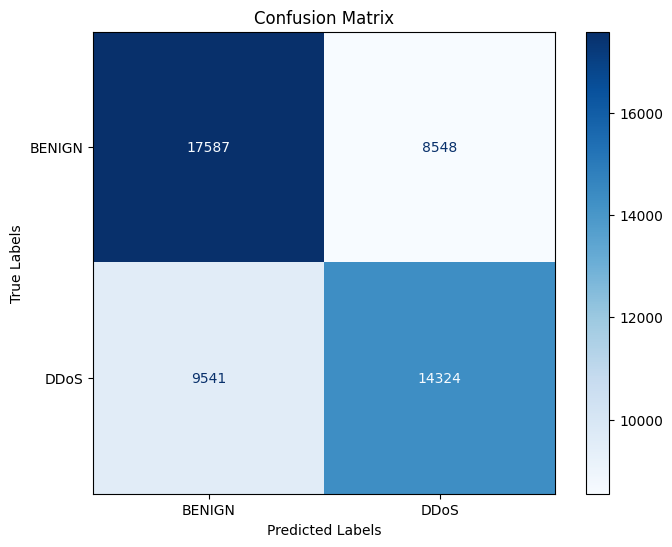

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

# Load the classified data and original labels
classified_df = pd.read_csv("ddos_predicted.csv")

# Calculate confusion matrix and metrics
ground_truth = classified_df['Ground_Label']
predicted = classified_df['DDoS_Predicted']

conf_matrix = confusion_matrix(ground_truth, predicted)
accuracy = accuracy_score(ground_truth, predicted)
report = classification_report(ground_truth, predicted, target_names=['BENIGN', 'DDoS'])

# Display metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy:", accuracy)

print("\nClassification Report:")
print(report)

# Visualize the confusion matrix with Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['BENIGN', 'DDoS']).plot(ax=ax, cmap='Blues', colorbar=True)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


AUC-PR for DDoS: 0.7086


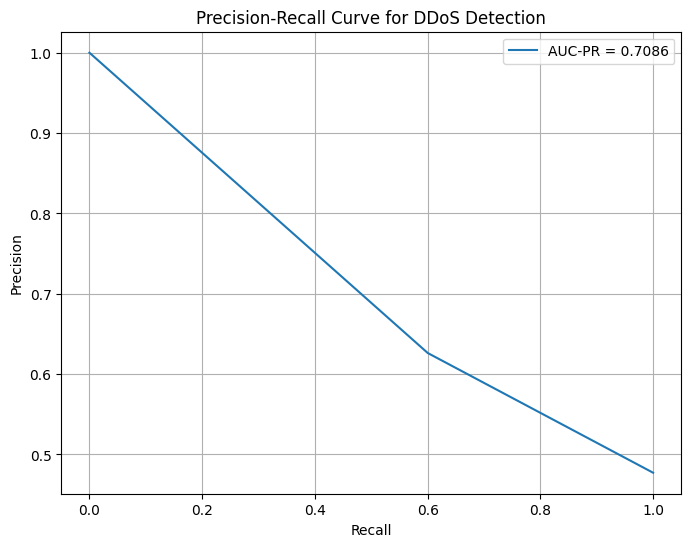

In [32]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Load the DDoS classified dataset
df = pd.read_csv("ddos_predicted.csv")

# Ensure the columns contain ground truth and predicted probabilities
# Replace 'Ground_Label' and 'Predicted_Probability' with actual column names
y_true = df['Ground_Label']  # Ground truth (0 for BENIGN, 1 for DDoS)
y_pred_prob = df['DDoS_Predicted']  # Predicted probabilities for DDoS

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
print(f"AUC-PR for DDoS: {auc_pr:.4f}")

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for DDoS Detection')
plt.legend(loc='best')
plt.grid()
plt.show()


Confusion Matrix:
[[46217  3727]
 [   33    23]]

Accuracy: 0.9248

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.93      0.96     49944
   Port Scan       0.01      0.41      0.01        56

    accuracy                           0.92     50000
   macro avg       0.50      0.67      0.49     50000
weighted avg       1.00      0.92      0.96     50000



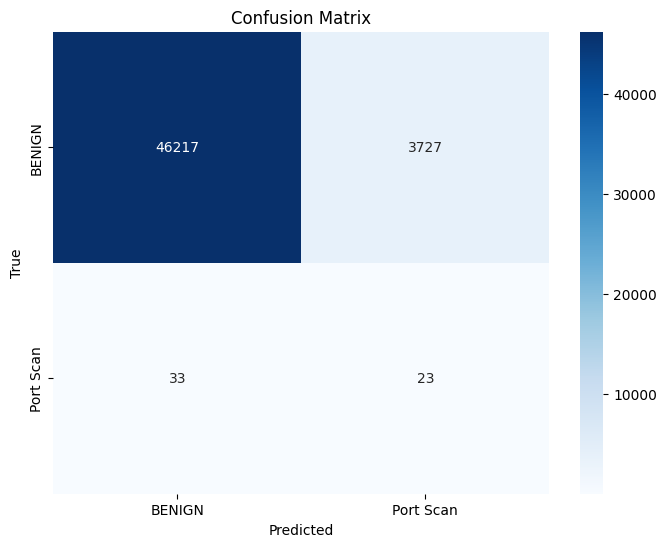

In [35]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the classified data
classified_df = pd.read_csv("PORTSCAN_PREDICTED (1).csv")

# Extract ground truth and predictions
ground_truth = classified_df['Ground_Label']
predicted = classified_df['PortScan_Predicted']

# Calculate metrics
conf_matrix = confusion_matrix(ground_truth, predicted)
accuracy = accuracy_score(ground_truth, predicted)
report = classification_report(ground_truth, predicted, target_names=['BENIGN', 'Port Scan'])

# Display metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy:", accuracy)

print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'Port Scan'], yticklabels=['BENIGN', 'Port Scan'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


AUC-PR for PortScan: 0.2088


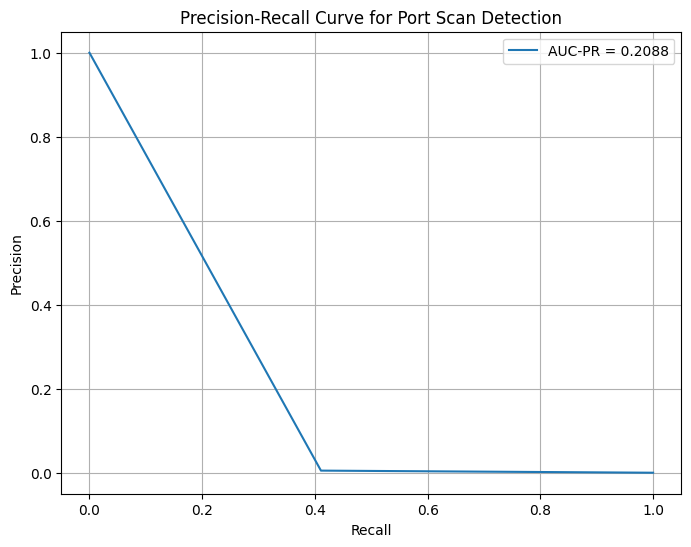

In [36]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Load the DDoS classified dataset
df = pd.read_csv("PORTSCAN_PREDICTED (1).csv")

# Ensure the columns contain ground truth and predicted probabilities
# Replace 'Ground_Label' and 'Predicted_Probability' with actual column names
y_true = df['Ground_Label']  # Ground truth (0 for BENIGN, 1 for DDoS)
y_pred_prob = df['PortScan_Predicted']  # Predicted probabilities for DDoS

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
print(f"AUC-PR for PortScan: {auc_pr:.4f}")

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Port Scan Detection')
plt.legend(loc='best')
plt.grid()
plt.show()

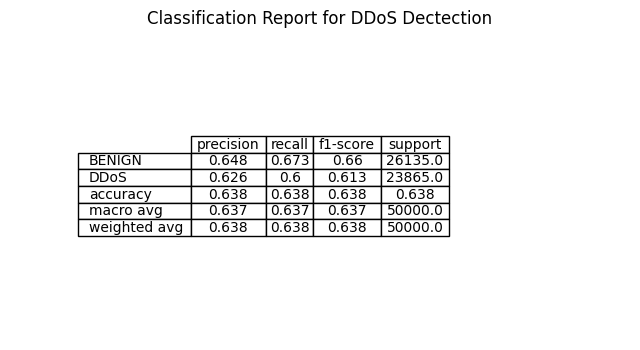

In [44]:
# Load your dataset
df = pd.read_csv("DDOS_PREDICTED.csv")  # Replace with your actual file

# Ground truth and predicted values
y_true = df['Ground_Label']  # Ground truth (0 for BENIGN, 1 for DDoS)
y_pred = df['DDoS_Predicted']  # Predicted labels for DDoS

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=['BENIGN', 'DDoS'], output_dict=True)

# Convert the report into a DataFrame for easy handling
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(
    cellText=report_df.values.round(3),
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    cellLoc="center",
    loc="center"
)

# Customize the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(report_df.columns))))

# Add title and display
plt.title("Classification Report for DDoS Dectection")
plt.show()


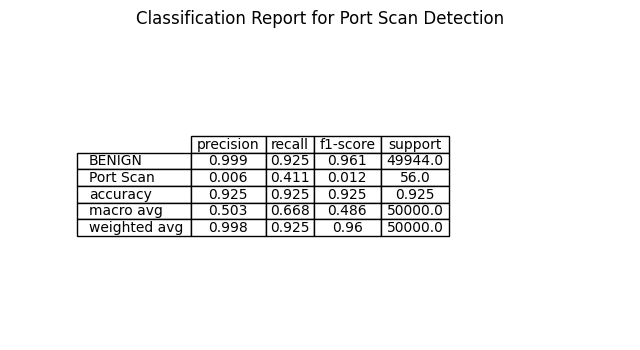

In [46]:

# Load your dataset
df = pd.read_csv("PORTSCAN_PREDICTED (1).csv")  # Replace with your actual file

# Ground truth and predicted values
y_true = df['Ground_Label']  # Ground truth (0 for BENIGN, 1 for Port Scan)
y_pred = df['PortScan_Predicted']  # Predicted labels for Port Scan

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=['BENIGN', 'Port Scan'], output_dict=True)

# Convert the report into a DataFrame for easy handling
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(
    cellText=report_df.values.round(3),
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    cellLoc="center",
    loc="center"
)

# Customize the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(report_df.columns))))

# Add title and display
plt.title("Classification Report for Port Scan Detection")
plt.show()
